References: 
* [P4 Multispectral Image Processing Guide](https://dl.djicdn.com/downloads/p4-multispectral/20200717/P4_Multispectral_Image_Processing_Guide_EN.pdf) 

In [ ]:
import os, glob, shutil
import cv2
import numpy as np
import pandas as pd
import helper.metadata as metadata

import exiftool
exiftoolPath = None
if os.name == 'nt':
    exiftoolPath = 'C:/exiftool/exiftool(-k).exe'
with exiftool.ExifTool(exiftoolPath) as exift:
    print('Exiftool works!')
    
print ('required libraries are imported...')

Exiftool works!
required libraries are imported...


In [2]:
SvyFolder = r"C:\UAV\Projects\DjiTest" # <----- EDIT THIS
NumBands = 5 # Blue, Green, Red, RedEdge, NIR
AddCropPixels = 10 # Edit if final reflectance images contain black edges
Overwrite = False

RawImages =  SvyFolder + '\\Raw'
ReflectanceImages =  SvyFolder + '\\Reflectance'

if Overwrite and os.path.exists(ReflectanceImages):
    shutil.rmtree(ReflectanceImages)
if not os.path.exists(ReflectanceImages):
    os.mkdir(ReflectanceImages)

In [3]:
file_set, I_sun_set = [], []
crop_left, crop_right, crop_bottom, crop_top = [], [], [], []
file_all, I_all = [], []
df = pd.DataFrame(columns=["SourceFile",
                           "FileName",
                           "Make",
                           "Model",
                           "BandName",
                           "RelativeAltitude",
                           "FocalLength",
                           "GPSAltitudeRef",
                           "GPSLatitudeRef",
                           "GPSLongitudeRef",
                           "GPSAltitude",
                           "GPSLatitude",
                           "GPSLongitude"])

files = glob.glob(RawImages + "\\*.tif")
n_files = len(files)
print("Total number of images:", n_files)
n_sets = int(len(files) / NumBands)
print("Total number of image sets:", n_sets)


# ----- Align phase difference caused by different camera locations -----

for i in range(n_sets):
    print("Processing {} / {} image sets".format(i+1, n_sets))
    
    file_name = files[0].split("\\")[-1]
    meta = metadata.Metadata(files[0], exiftoolPath)
    file_id = file_name.split("DJI_")[1].split(".TIF")[0]
    set_id = str(file_id[0:-len(str(NumBands))])
    band_id = str(file_id[-len(str(NumBands))])
    
    # Get all bands from the same set
    for j in list(range(1,NumBands+1)):
        
        file_name = "DJI_" + set_id + str(j) + ".TIF"
        file_path = os.path.join(RawImages, file_name)
        image = cv2.imread(file_path, cv2.COLOR_BGR2GRAY)
        meta = metadata.Metadata(file_path, exiftoolPath)
        file_set.append(file_name)
        files.remove(file_path)
        
        # Save meta
        df_img = {
            "SourceFile": os.path.join(ReflectanceImages, file_name),
            "FileName": file_name,
            "Make": meta.get_item("XMP:Make"),
            "Model": meta.get_item("XMP:Model"),
            "BandName": meta.get_item("XMP:BandName"),
            "RelativeAltitude": meta.get_item("XMP:RelativeAltitude"),
            "FocalLength": meta.get_item("EXIF:FocalLength"),
            "GPSAltitudeRef": meta.get_item("EXIF:GPSAltitudeRef"),
            "GPSLatitudeRef": meta.get_item("EXIF:GPSLatitudeRef"),
            "GPSLongitudeRef": meta.get_item("EXIF:GPSLongitudeRef"),
            "GPSAltitude": meta.get_item("EXIF:GPSAltitude"),
            "GPSLatitude": meta.get_item("EXIF:GPSLatitude"),
            "GPSLongitude": meta.get_item("EXIF:GPSLongitude")
        }
        df = df.append(df_img, ignore_index = True)
        
        # Translate image
        xoff = meta.get_item("XMP:RelativeOpticalCenterX")
        yoff = meta.get_item("XMP:RelativeOpticalCenterY")
        height, width = image.shape[:2] 
        T = np.float32([[1, 0, -xoff], [0, 1, -yoff]])
        I_trans = cv2.warpAffine(image, T, (width, height))
        
        # Cropping parameters from translation
        if xoff >=0: 
            crop_left_trans = int(np.abs(np.ceil(xoff)))
            crop_right_trans = 0
        else:
            crop_left_trans = 0
            crop_right_trans = int(np.abs(np.floor(xoff)))
        if yoff >=0: 
            crop_bottom_trans = int(np.abs(np.ceil(yoff)))
            crop_top_trans = 0
        else:
            crop_bottom_trans = 0
            crop_top_trans = int(np.abs(np.floor(yoff)))
        crop_left.append(crop_left_trans)
        crop_right.append(crop_right_trans)
        crop_bottom.append(crop_bottom_trans)
        crop_top.append(crop_top_trans)
        
        
        # ----- Correction -----
        
        # Normalize 16-bit values
        I_band = I_trans / 65535 
        I_black = meta.get_item("EXIF:BlackLevel") / 65535 
        I_norm = I_band - I_black

        # Vignetting correction
        center_x = meta.get_item("XMP:CalibratedOpticalCenterX")
        center_y = meta.get_item("XMP:CalibratedOpticalCenterY")
        height, width = I_norm.shape[:2]
        coord_x, coord_y = np.meshgrid(range(1, width+1), range(1, height+1))
        r = np.sqrt(((coord_x-center_x)**2) + ((coord_y-center_y)**2))
        k = [float(i) for i in meta.get_item("XMP:VignettingData").split(",")]
        I_vig = I_norm * (k[5]*r**6 + k[4]*r**5 + k[3]*r**4 + k[2]*r**3 + k[1]*r**2 + k[0]*r + 1.0)

        # Distortion correction
        dewarp = meta.get_item("XMP:DewarpData").split(";")[1]
        fx, fy, cx, cy, k1, k2, p1, p2, k3 = [float(i) for i in dewarp.split(",")]
        dist = np.array([[k1, k2, p1, p2, k3]])
        mtx = np.array([[fx, 0, center_x + cx], [0, fy, center_y + cy], [0, 0, 1]])
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (width,height), 1, (width,height))
        I_dst = cv2.undistort(I_vig, mtx, dist, None, newcameramtx)
        
        # Cropping parameters from distortion correction
        x, y, w, h = roi
        crop_left.append(x)
        crop_right.append(x)
        crop_bottom.append(y)
        crop_top.append(y)
        
        # Calculate image signal value
        val_gain = meta.get_item("XMP:SensorGain")
        val_etime = meta.get_item("EXIF:ExposureTime")
        I_signal = I_dst / (val_gain * (val_etime/1e6))

        # Sunlight sensor adjustment
        p_camera = meta.get_item("XMP:SensorGainAdjustment")
        irr = meta.get_item("XMP:Irradiance")
        I_sun = I_signal * p_camera / irr
        I_sun_set.append(I_sun)
    
    # Compare cropping parameters from translation and distortion correction and crop the larger area
    # As black edges may not be removed after distortion correction, additional pixels are cropped
    for k in range(len(I_sun_set)):
        image_k = I_sun_set[k]
        I_crop = image_k[np.max(crop_left)+AddCropPixels:height-np.max(crop_right)-AddCropPixels, 
                         np.max(crop_bottom)+AddCropPixels:width-np.max(crop_top)-AddCropPixels]
        I_all.append(I_crop)
        file_all.append(file_set[k])
        
    file_set, I_sun_set = [], []
    crop_left, crop_right, crop_bottom, crop_top = [], [], [], []
print("Completed!")

Total number of images: 1315
Total number of image sets: 263
Processing 1 / 263 image sets
Processing 2 / 263 image sets
Processing 3 / 263 image sets
Processing 4 / 263 image sets
Processing 5 / 263 image sets
Processing 6 / 263 image sets
Processing 7 / 263 image sets
Processing 8 / 263 image sets
Processing 9 / 263 image sets
Processing 10 / 263 image sets
Processing 11 / 263 image sets
Processing 12 / 263 image sets
Processing 13 / 263 image sets
Processing 14 / 263 image sets
Processing 15 / 263 image sets
Processing 16 / 263 image sets
Processing 17 / 263 image sets
Processing 18 / 263 image sets
Processing 19 / 263 image sets
Processing 20 / 263 image sets
Processing 21 / 263 image sets
Processing 22 / 263 image sets
Processing 23 / 263 image sets
Processing 24 / 263 image sets
Processing 25 / 263 image sets
Processing 26 / 263 image sets
Processing 27 / 263 image sets
Processing 28 / 263 image sets
Processing 29 / 263 image sets
Processing 30 / 263 image sets
Processing 31 / 26

Processing 259 / 263 image sets
Processing 260 / 263 image sets
Processing 261 / 263 image sets
Processing 262 / 263 image sets
Processing 263 / 263 image sets
Completed!


In [4]:
"""
As DJI P4M does not provide the conversion parameter, p_nir, to convert image signal values to reflectance values,
reflectance is currently estimated by normalizing sunlight sensor adjusted values, I_sensor, to [0,1]. 

If better images are available (e.g. land areas produced using Agisoft Metashape), 
the normalized I_sensor values can be adjusted to fit the better images.

However, datasets obtained from different flight missions will remain incomparable without radiometric calibration using calibrated reflectance panels.
"""
I_max = np.max(I_all)

for i in range(len(I_all)):
    I_ref = I_all[i] / I_max
    I_ref = I_ref.astype(np.float32)
    if Overwrite or not os.path.exists(os.path.join(ReflectanceImages, file_name)):
        print("Exporting image {} / {}: {}".format(i+1, len(I_all), file_all[i]))
        cv2.imwrite(os.path.join(ReflectanceImages, file_all[i]) ,I_ref)
    
print("Completed!")

Exporting image 1 / 1315: DJI_0011.TIF
Exporting image 2 / 1315: DJI_0012.TIF
Exporting image 3 / 1315: DJI_0013.TIF
Exporting image 4 / 1315: DJI_0014.TIF
Exporting image 5 / 1315: DJI_0015.TIF
Exporting image 6 / 1315: DJI_0021.TIF
Exporting image 7 / 1315: DJI_0022.TIF
Exporting image 8 / 1315: DJI_0023.TIF
Exporting image 9 / 1315: DJI_0024.TIF
Exporting image 10 / 1315: DJI_0025.TIF
Exporting image 11 / 1315: DJI_0031.TIF
Exporting image 12 / 1315: DJI_0032.TIF
Exporting image 13 / 1315: DJI_0033.TIF
Exporting image 14 / 1315: DJI_0034.TIF
Exporting image 15 / 1315: DJI_0035.TIF
Exporting image 16 / 1315: DJI_0041.TIF
Exporting image 17 / 1315: DJI_0042.TIF
Exporting image 18 / 1315: DJI_0043.TIF
Exporting image 19 / 1315: DJI_0044.TIF
Exporting image 20 / 1315: DJI_0045.TIF
Exporting image 21 / 1315: DJI_0051.TIF
Exporting image 22 / 1315: DJI_0052.TIF
Exporting image 23 / 1315: DJI_0053.TIF
Exporting image 24 / 1315: DJI_0054.TIF
Exporting image 25 / 1315: DJI_0055.TIF
Exporting

Exporting image 204 / 1315: DJI_0414.TIF
Exporting image 205 / 1315: DJI_0415.TIF
Exporting image 206 / 1315: DJI_0421.TIF
Exporting image 207 / 1315: DJI_0422.TIF
Exporting image 208 / 1315: DJI_0423.TIF
Exporting image 209 / 1315: DJI_0424.TIF
Exporting image 210 / 1315: DJI_0425.TIF
Exporting image 211 / 1315: DJI_0431.TIF
Exporting image 212 / 1315: DJI_0432.TIF
Exporting image 213 / 1315: DJI_0433.TIF
Exporting image 214 / 1315: DJI_0434.TIF
Exporting image 215 / 1315: DJI_0435.TIF
Exporting image 216 / 1315: DJI_0441.TIF
Exporting image 217 / 1315: DJI_0442.TIF
Exporting image 218 / 1315: DJI_0443.TIF
Exporting image 219 / 1315: DJI_0444.TIF
Exporting image 220 / 1315: DJI_0445.TIF
Exporting image 221 / 1315: DJI_0451.TIF
Exporting image 222 / 1315: DJI_0452.TIF
Exporting image 223 / 1315: DJI_0453.TIF
Exporting image 224 / 1315: DJI_0454.TIF
Exporting image 225 / 1315: DJI_0455.TIF
Exporting image 226 / 1315: DJI_0461.TIF
Exporting image 227 / 1315: DJI_0462.TIF
Exporting image 

Exporting image 404 / 1315: DJI_0814.TIF
Exporting image 405 / 1315: DJI_0815.TIF
Exporting image 406 / 1315: DJI_0821.TIF
Exporting image 407 / 1315: DJI_0822.TIF
Exporting image 408 / 1315: DJI_0823.TIF
Exporting image 409 / 1315: DJI_0824.TIF
Exporting image 410 / 1315: DJI_0825.TIF
Exporting image 411 / 1315: DJI_0831.TIF
Exporting image 412 / 1315: DJI_0832.TIF
Exporting image 413 / 1315: DJI_0833.TIF
Exporting image 414 / 1315: DJI_0834.TIF
Exporting image 415 / 1315: DJI_0835.TIF
Exporting image 416 / 1315: DJI_0841.TIF
Exporting image 417 / 1315: DJI_0842.TIF
Exporting image 418 / 1315: DJI_0843.TIF
Exporting image 419 / 1315: DJI_0844.TIF
Exporting image 420 / 1315: DJI_0845.TIF
Exporting image 421 / 1315: DJI_0851.TIF
Exporting image 422 / 1315: DJI_0852.TIF
Exporting image 423 / 1315: DJI_0853.TIF
Exporting image 424 / 1315: DJI_0854.TIF
Exporting image 425 / 1315: DJI_0855.TIF
Exporting image 426 / 1315: DJI_0861.TIF
Exporting image 427 / 1315: DJI_0862.TIF
Exporting image 

Exporting image 605 / 1315: DJI_1215.TIF
Exporting image 606 / 1315: DJI_1221.TIF
Exporting image 607 / 1315: DJI_1222.TIF
Exporting image 608 / 1315: DJI_1223.TIF
Exporting image 609 / 1315: DJI_1224.TIF
Exporting image 610 / 1315: DJI_1225.TIF
Exporting image 611 / 1315: DJI_1231.TIF
Exporting image 612 / 1315: DJI_1232.TIF
Exporting image 613 / 1315: DJI_1233.TIF
Exporting image 614 / 1315: DJI_1234.TIF
Exporting image 615 / 1315: DJI_1235.TIF
Exporting image 616 / 1315: DJI_1241.TIF
Exporting image 617 / 1315: DJI_1242.TIF
Exporting image 618 / 1315: DJI_1243.TIF
Exporting image 619 / 1315: DJI_1244.TIF
Exporting image 620 / 1315: DJI_1245.TIF
Exporting image 621 / 1315: DJI_1251.TIF
Exporting image 622 / 1315: DJI_1252.TIF
Exporting image 623 / 1315: DJI_1253.TIF
Exporting image 624 / 1315: DJI_1254.TIF
Exporting image 625 / 1315: DJI_1255.TIF
Exporting image 626 / 1315: DJI_1261.TIF
Exporting image 627 / 1315: DJI_1262.TIF
Exporting image 628 / 1315: DJI_1263.TIF
Exporting image 

Exporting image 806 / 1315: DJI_1621.TIF
Exporting image 807 / 1315: DJI_1622.TIF
Exporting image 808 / 1315: DJI_1623.TIF
Exporting image 809 / 1315: DJI_1624.TIF
Exporting image 810 / 1315: DJI_1625.TIF
Exporting image 811 / 1315: DJI_1631.TIF
Exporting image 812 / 1315: DJI_1632.TIF
Exporting image 813 / 1315: DJI_1633.TIF
Exporting image 814 / 1315: DJI_1634.TIF
Exporting image 815 / 1315: DJI_1635.TIF
Exporting image 816 / 1315: DJI_1641.TIF
Exporting image 817 / 1315: DJI_1642.TIF
Exporting image 818 / 1315: DJI_1643.TIF
Exporting image 819 / 1315: DJI_1644.TIF
Exporting image 820 / 1315: DJI_1645.TIF
Exporting image 821 / 1315: DJI_1651.TIF
Exporting image 822 / 1315: DJI_1652.TIF
Exporting image 823 / 1315: DJI_1653.TIF
Exporting image 824 / 1315: DJI_1654.TIF
Exporting image 825 / 1315: DJI_1655.TIF
Exporting image 826 / 1315: DJI_1661.TIF
Exporting image 827 / 1315: DJI_1662.TIF
Exporting image 828 / 1315: DJI_1663.TIF
Exporting image 829 / 1315: DJI_1664.TIF
Exporting image 

Exporting image 1006 / 1315: DJI_2021.TIF
Exporting image 1007 / 1315: DJI_2022.TIF
Exporting image 1008 / 1315: DJI_2023.TIF
Exporting image 1009 / 1315: DJI_2024.TIF
Exporting image 1010 / 1315: DJI_2025.TIF
Exporting image 1011 / 1315: DJI_2031.TIF
Exporting image 1012 / 1315: DJI_2032.TIF
Exporting image 1013 / 1315: DJI_2033.TIF
Exporting image 1014 / 1315: DJI_2034.TIF
Exporting image 1015 / 1315: DJI_2035.TIF
Exporting image 1016 / 1315: DJI_2041.TIF
Exporting image 1017 / 1315: DJI_2042.TIF
Exporting image 1018 / 1315: DJI_2043.TIF
Exporting image 1019 / 1315: DJI_2044.TIF
Exporting image 1020 / 1315: DJI_2045.TIF
Exporting image 1021 / 1315: DJI_2051.TIF
Exporting image 1022 / 1315: DJI_2052.TIF
Exporting image 1023 / 1315: DJI_2053.TIF
Exporting image 1024 / 1315: DJI_2054.TIF
Exporting image 1025 / 1315: DJI_2055.TIF
Exporting image 1026 / 1315: DJI_2061.TIF
Exporting image 1027 / 1315: DJI_2062.TIF
Exporting image 1028 / 1315: DJI_2063.TIF
Exporting image 1029 / 1315: DJI_2

Exporting image 1202 / 1315: DJI_2412.TIF
Exporting image 1203 / 1315: DJI_2413.TIF
Exporting image 1204 / 1315: DJI_2414.TIF
Exporting image 1205 / 1315: DJI_2415.TIF
Exporting image 1206 / 1315: DJI_2421.TIF
Exporting image 1207 / 1315: DJI_2422.TIF
Exporting image 1208 / 1315: DJI_2423.TIF
Exporting image 1209 / 1315: DJI_2424.TIF
Exporting image 1210 / 1315: DJI_2425.TIF
Exporting image 1211 / 1315: DJI_2431.TIF
Exporting image 1212 / 1315: DJI_2432.TIF
Exporting image 1213 / 1315: DJI_2433.TIF
Exporting image 1214 / 1315: DJI_2434.TIF
Exporting image 1215 / 1315: DJI_2435.TIF
Exporting image 1216 / 1315: DJI_2441.TIF
Exporting image 1217 / 1315: DJI_2442.TIF
Exporting image 1218 / 1315: DJI_2443.TIF
Exporting image 1219 / 1315: DJI_2444.TIF
Exporting image 1220 / 1315: DJI_2445.TIF
Exporting image 1221 / 1315: DJI_2451.TIF
Exporting image 1222 / 1315: DJI_2452.TIF
Exporting image 1223 / 1315: DJI_2453.TIF
Exporting image 1224 / 1315: DJI_2454.TIF
Exporting image 1225 / 1315: DJI_2

In [5]:
df.to_csv(os.path.join(ReflectanceImages, "meta.csv"), index=False)

cwd = os.getcwd()
os.chdir(ReflectanceImages)
!exiftool -csv=meta.csv -overwrite_original {ReflectanceImages}
os.chdir(cwd)
print("Completed!")

Completed!


    1 directories scanned
 1315 image files updated


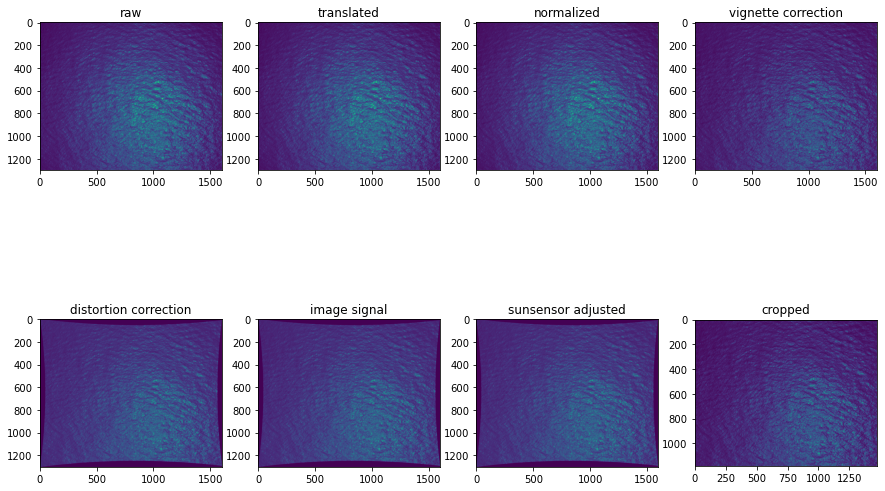

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.subplot(2,4,1), plt.imshow(image), plt.title("raw")
plt.subplot(2,4,2), plt.imshow(I_trans), plt.title("translated")
plt.subplot(2,4,3), plt.imshow(I_norm), plt.title("normalized")
plt.subplot(2,4,4), plt.imshow(I_vig), plt.title("vignette correction")
plt.subplot(2,4,5), plt.imshow(I_dst), plt.title("distortion correction")
plt.subplot(2,4,6), plt.imshow(I_signal), plt.title("image signal")
plt.subplot(2,4,7), plt.imshow(I_sun), plt.title("sunsensor adjusted")
plt.subplot(2,4,8), plt.imshow(I_crop), plt.title("cropped")
plt.show()

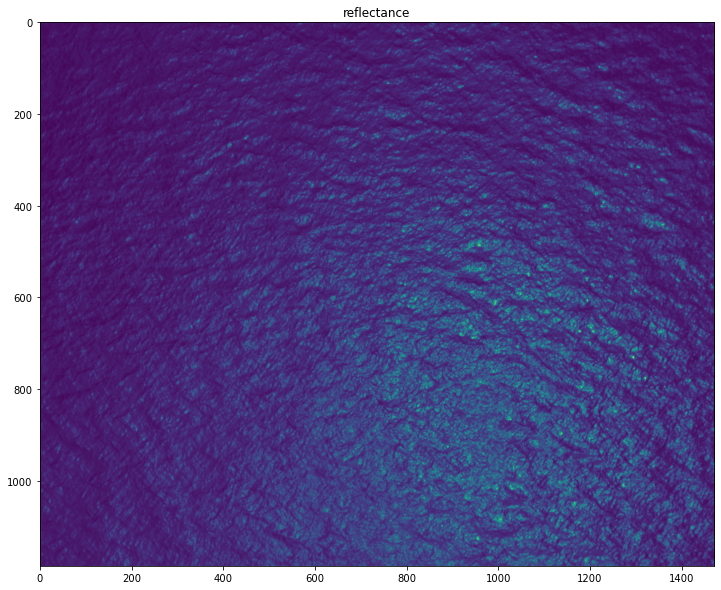

In [7]:
# NOTE: Edit AddCropPixels if final reflectance images contain black edges
plt.figure(figsize=(20,10)), plt.imshow(I_ref), plt.title("reflectance")
plt.show()